In [1]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


## Set up parameters, create isochrone grid

In [2]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F182M']
filters = ['m_jwst_F115W', 'm_jwst_F182M']
iso_dir = 'isochrones/'
metallicity = 0

In [3]:
# read nbody data
path_to_data = '../../../../../../storage/jfarias/Data/Orion/massive_clusters/M3000new/sigma0p1/fiducial/sfe_ff100/00/'
snapshot = Reader.read_snapshot(path_to_data, time = 20)

# convert snapshot values from nbody units to astrophysical, extract masses
snapshot.to_physical()

# read ages for simulated stars
cluster_table = converter.to_spicea_table(snapshot)

print(cluster_table)

        mass        isMultiple        compMass            systemMass              e                 log_a               age        
------------------- ---------- --------------------- ------------------- -------------------- ------------------ ------------------
0.15548709189209567        0.0                    [] 0.15548709189209567                  nan                nan 19.927175803177988
0.05590752081313288        0.0                    [] 0.05590752081313288                  nan                nan 19.927175803177988
 15.152175805062605        0.0                    []  15.152175805062605                  nan                nan 19.896860825946256
0.19833611713212587        0.0                    [] 0.19833611713212587                  nan                nan 19.980296008051358
                ...        ...                   ...                 ...                  ...                ...                ...
 0.7087321180887948        1.0  [0.3160290611074498]  1.0247611791962445 0.0

In [4]:
masses = cluster_table['mass']
level_ages = cluster_table['age']

for i in range(len(level_ages)):
    level_ages[i] = level_ages[i] * 1e6

# convert log ages from log(Myr) to log(yr)
log_ages = np.log10(level_ages)

# print(log_ages)
print("Min log age = " + str(min(log_ages)))
print("Max log age = " + str(max(log_ages)))

# print(level_ages)
print("Min level age = " + str(min(level_ages)))
print("Max level age = " + str(max(level_ages)))

Min log age = 7.297141350870765
Max log age = 7.301155348493374
Min level age = 19821720.63142749
Max level age = 20005773.544311523


In [5]:
# find index of first binary, create array of companion masses
first_binary = 0
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        first_binary = i
        break
print(first_binary)

compMasses = []
for i in range(len(cluster_table)):
    if cluster_table['isMultiple'][i] == 1.0:
        compMasses.append(cluster_table['compMass'][i][0])
print(compMasses)

1352
[0.16312509029104827, 0.09636490446440792, 0.017003777999204207, 0.03636643773183382, 0.21849298240279427, 0.10166459547430746, 0.03651675631669997, 0.019132423710002903, 0.12247264926103713, 0.6385500001324462, 0.2022302569658592, 0.07471903553293849, 0.16814292142663018, 0.011007644292289143, 0.0230523225129767, 0.1609042880961581, 0.2688387764755287, 0.012694034520736917, 0.09389877662294215, 0.024808470564410257, 0.537538199511473, 0.10413768535122994, 0.1908368021249771, 0.1895631651814792, 0.09792501441534668, 0.05503713712096214, 0.014894501085541238, 0.16944725553078624, 0.03849610313773155, 0.03068110511487832, 0.010428669715904573, 0.08125256687517324, 0.16246923291724738, 0.1713331396330831, 0.010724686463596327, 0.030670575167798916, 0.02728213963323672, 0.045772770042914156, 0.15501195511789118, 0.026778635366288318, 0.016255424024083663, 0.03575262254606042, 0.1309257580510967, 0.7052331632631441, 0.05378693756462908, 0.09028542237526906, 0.03368280383489044, 0.55107

In [6]:
start = (min(level_ages) // 0.5e6) * 0.5e6
end = (max(level_ages) // 0.5e6) * 0.5e6 + 2 * 0.5e6
increment = 0.5e6  # 500,000

# Create age arrays
level_age_arr = np.arange(start, end, increment)
log_age_arr = np.log10(level_age_arr)

print(log_age_arr)
print(level_age_arr)

[7.29003461 7.30103    7.31175386]
[19500000. 20000000. 20500000.]


In [7]:
# create isochrone grid - if this is the first time, then this is going to take an hour lmfao
instances = np.empty(len(log_age_arr), dtype=object)

for i in range(len(log_age_arr)):
    my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
    instances[i] = my_iso
        
print("isochrone generation done")

isochrone generation done


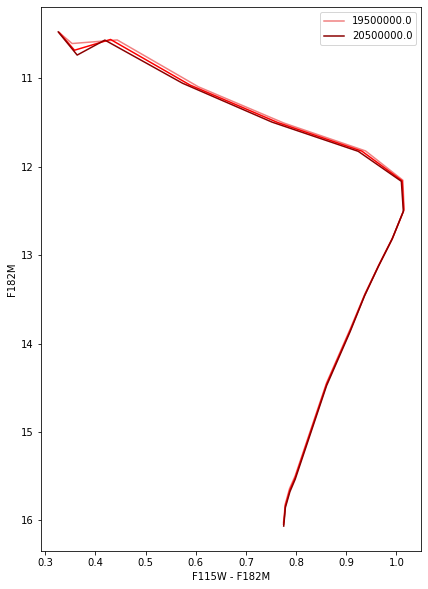

In [8]:
# identify array indeces, create array for labels and colors
idx_arr = range(0, len(log_age_arr))
if len(idx_arr) > 3:
    idx_arr = idx_arr[::2]

# Plot CMD
fig, axes = py.subplots(figsize=(15, 10))
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

In [9]:
import sys
sys.path.append('/scratch/wyz5rge/synthetic-hr/12-18')
import interpolatorExp as interpolator

level_ages_myr = level_ages / 1e6
# print(level_ages_myr)

# create array of stars
stars = np.empty(len(cluster_table), dtype=object)

# perform interpolation for each star
for i in range(len(stars)):
    # print(str(i) + " " + str(level_ages_myr[i]) + " " + str(masses[i]))
    stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
# convert luminosity values to solar luminosities
watts_to_lsun = 1.0 / (3.846e26) # conversion factor for watts to Lsun

for i in range(len(stars)):
    if stars[i] is None:
        continue
    stars[i][0] = stars[i][0] * watts_to_lsun
    
for i in range(len(stars)):
    print(stars[i])

Desired mass 0.05590752081313288 is outside the range of the isochrone.
Desired mass 0.05590752081313288 is outside the range of the isochrone.
Desired mass 15.152175805062605 is outside the range of the isochrone.
Desired mass 15.152175805062605 is outside the range of the isochrone.
Desired mass 0.024091260296864203 is outside the range of the isochrone.
Desired mass 0.024091260296864203 is outside the range of the isochrone.
Desired mass 85.6411399717537 is outside the range of the isochrone.
Desired mass 85.6411399717537 is outside the range of the isochrone.
Desired mass 0.06956745444329208 is outside the range of the isochrone.
Desired mass 0.06956745444329208 is outside the range of the isochrone.
Desired mass 0.02640447135116942 is outside the range of the isochrone.
Desired mass 0.02640447135116942 is outside the range of the isochrone.
Desired mass 1.5874859352395498 is outside the range of the isochrone.
Desired mass 1.5874859352395498 is outside the range of the isochrone.


Desired mass 0.06299018413873413 is outside the range of the isochrone.
Desired mass 0.06299018413873413 is outside the range of the isochrone.
Desired mass 0.03717862814664841 is outside the range of the isochrone.
Desired mass 0.03717862814664841 is outside the range of the isochrone.
Desired mass 0.027155654945961647 is outside the range of the isochrone.
Desired mass 0.027155654945961647 is outside the range of the isochrone.
Desired mass 0.04305133860815552 is outside the range of the isochrone.
Desired mass 0.04305133860815552 is outside the range of the isochrone.
Desired mass 0.04109451267704722 is outside the range of the isochrone.
Desired mass 0.04109451267704722 is outside the range of the isochrone.
Desired mass 0.029854124575104387 is outside the range of the isochrone.
Desired mass 0.029854124575104387 is outside the range of the isochrone.
Desired mass 0.059264831743607076 is outside the range of the isochrone.
Desired mass 0.059264831743607076 is outside the range of t

Desired mass 0.05344193252794389 is outside the range of the isochrone.
Desired mass 0.05344193252794389 is outside the range of the isochrone.
Desired mass 0.047458667059310664 is outside the range of the isochrone.
Desired mass 0.047458667059310664 is outside the range of the isochrone.
Desired mass 0.03188450942160066 is outside the range of the isochrone.
Desired mass 0.03188450942160066 is outside the range of the isochrone.
Desired mass 0.01943236486511639 is outside the range of the isochrone.
Desired mass 0.01943236486511639 is outside the range of the isochrone.
Desired mass 1.449742524057735 is outside the range of the isochrone.
Desired mass 1.449742524057735 is outside the range of the isochrone.
Desired mass 0.02580168929523381 is outside the range of the isochrone.
Desired mass 0.02580168929523381 is outside the range of the isochrone.
Desired mass 0.04131991826612342 is outside the range of the isochrone.
Desired mass 0.04131991826612342 is outside the range of the isoch

Desired mass 0.02512364407521134 is outside the range of the isochrone.
Desired mass 0.02512364407521134 is outside the range of the isochrone.
Desired mass 0.026593054364861094 is outside the range of the isochrone.
Desired mass 0.026593054364861094 is outside the range of the isochrone.
Desired mass 0.06692828983068466 is outside the range of the isochrone.
Desired mass 0.06692828983068466 is outside the range of the isochrone.
Desired mass 0.06278829166231406 is outside the range of the isochrone.
Desired mass 0.06278829166231406 is outside the range of the isochrone.
Desired mass 0.06477721902550365 is outside the range of the isochrone.
Desired mass 0.06477721902550365 is outside the range of the isochrone.
Desired mass 1.8795288801193237 is outside the range of the isochrone.
Desired mass 1.8795288801193237 is outside the range of the isochrone.
Desired mass 4.705798550982377 is outside the range of the isochrone.
Desired mass 4.705798550982377 is outside the range of the isochro

Desired mass 0.03014186935521681 is outside the range of the isochrone.
Desired mass 0.03014186935521681 is outside the range of the isochrone.
Desired mass 0.012899982564743359 is outside the range of the isochrone.
Desired mass 0.012899982564743359 is outside the range of the isochrone.
Desired mass 0.05347176131099795 is outside the range of the isochrone.
Desired mass 0.05347176131099795 is outside the range of the isochrone.
Desired mass 0.059970329910022206 is outside the range of the isochrone.
Desired mass 0.059970329910022206 is outside the range of the isochrone.
Desired mass 2.102751686697909 is outside the range of the isochrone.
Desired mass 2.102751686697909 is outside the range of the isochrone.
Desired mass 0.03596118908043647 is outside the range of the isochrone.
Desired mass 0.03596118908043647 is outside the range of the isochrone.
Desired mass 0.06013617013310024 is outside the range of the isochrone.
Desired mass 0.06013617013310024 is outside the range of the iso

Desired mass 0.06713698906497433 is outside the range of the isochrone.
Desired mass 0.04211746231160678 is outside the range of the isochrone.
Desired mass 0.04211746231160678 is outside the range of the isochrone.
Desired mass 0.025305122186674134 is outside the range of the isochrone.
Desired mass 0.025305122186674134 is outside the range of the isochrone.
Desired mass 0.047286362994197265 is outside the range of the isochrone.
Desired mass 0.047286362994197265 is outside the range of the isochrone.
Desired mass 0.01487911994944025 is outside the range of the isochrone.
Desired mass 0.01487911994944025 is outside the range of the isochrone.
Desired mass 0.04700913295414384 is outside the range of the isochrone.
Desired mass 0.04700913295414384 is outside the range of the isochrone.
Desired mass 0.037678829519299885 is outside the range of the isochrone.
Desired mass 0.037678829519299885 is outside the range of the isochrone.
Desired mass 0.057037140104408336 is outside the range of 

Desired mass 0.028546140910281678 is outside the range of the isochrone.
Desired mass 0.028546140910281678 is outside the range of the isochrone.
Desired mass 0.044984426501790145 is outside the range of the isochrone.
Desired mass 0.044984426501790145 is outside the range of the isochrone.
Desired mass 0.06710990833956959 is outside the range of the isochrone.
Desired mass 0.06710990833956959 is outside the range of the isochrone.
Desired mass 0.04956657175811372 is outside the range of the isochrone.
Desired mass 0.04956657175811372 is outside the range of the isochrone.
Desired mass 0.03171579104886849 is outside the range of the isochrone.
Desired mass 0.03171579104886849 is outside the range of the isochrone.
Desired mass 0.03867943091382009 is outside the range of the isochrone.
Desired mass 0.03867943091382009 is outside the range of the isochrone.
Desired mass 0.04687344429559983 is outside the range of the isochrone.
Desired mass 0.04687344429559983 is outside the range of the

Desired mass 0.03708903570845044 is outside the range of the isochrone.
Desired mass 0.03708903570845044 is outside the range of the isochrone.
Desired mass 0.06812172503444466 is outside the range of the isochrone.
Desired mass 0.06812172503444466 is outside the range of the isochrone.
Desired mass 0.05118833750719928 is outside the range of the isochrone.
Desired mass 0.05118833750719928 is outside the range of the isochrone.
Desired mass 0.021491099638601362 is outside the range of the isochrone.
Desired mass 0.021491099638601362 is outside the range of the isochrone.
Desired mass 0.03783139538760416 is outside the range of the isochrone.
Desired mass 0.03783139538760416 is outside the range of the isochrone.
Desired mass 0.016854329283512118 is outside the range of the isochrone.
Desired mass 0.016854329283512118 is outside the range of the isochrone.
Desired mass 5.112814183747455 is outside the range of the isochrone.
Desired mass 5.112814183747455 is outside the range of the iso

Desired mass 0.06566275122984014 is outside the range of the isochrone.
Desired mass 0.06566275122984014 is outside the range of the isochrone.
Desired mass 0.036287128076766005 is outside the range of the isochrone.
Desired mass 0.036287128076766005 is outside the range of the isochrone.
Desired mass 0.04136073567258041 is outside the range of the isochrone.
Desired mass 0.04136073567258041 is outside the range of the isochrone.
Desired mass 0.06184639983825737 is outside the range of the isochrone.
Desired mass 0.06184639983825737 is outside the range of the isochrone.
Desired mass 0.033396486422877535 is outside the range of the isochrone.
Desired mass 0.033396486422877535 is outside the range of the isochrone.
Desired mass 0.04231069763318475 is outside the range of the isochrone.
Desired mass 0.04231069763318475 is outside the range of the isochrone.
Desired mass 0.058774413702788096 is outside the range of the isochrone.
Desired mass 0.058774413702788096 is outside the range of t

[0.0995197157534112, 3720.759, 4.445, 13.827, 12.838]
None
[0.021007367498556945, 3261.243, 4.42, 15.335, 14.475]
None
None
[0.005811289827531859, 2982.511, 4.422, 16.631, 15.853]
None
[0.030879152448876918, 3341.809, 4.418, 14.983, 14.095]
[0.006449068517490044, 3005.889, 4.423, 16.528, 15.745]
[0.07979506525682306, 3626.996, 4.44, 14.032, 13.064]
[0.01356134308664629, 3145.406, 4.426, 15.894, 15.069]
[0.04792927574230863, 3457.095, 4.422, 14.533, 13.608]
[0.0075066818962075494, 3043.408, 4.428, 16.374, 15.58]
None
[0.03974551397259928, 3408.702, 4.418, 14.706, 13.795]
[0.00939280475338929, 3081.36, 4.431, 16.207, 15.402]
None
[0.0142547668456164, 3156.54, 4.426, 15.842, 15.014]
[0.0057313388055860595, 2979.288, 4.423, 16.646, 15.868]
[0.2863819077276227, 4334.112, 4.428, 12.863, 11.91]
[0.09838057329927108, 3714.281, 4.444, 13.839, 12.851]
[0.13084000559181388, 3850.753, 4.446, 13.583, 12.575]
[0.025101135437706226, 3294.717, 4.418, 15.184, 14.312]
[0.012680475914991779, 3131.771, 4.

None
[0.012868606355756497, 3134.402, 4.426, 15.945, 15.124]
None
None
[0.008724141086679283, 3070.621, 4.43, 16.255, 15.454]
[0.012636637008206783, 3131.523, 4.428, 15.963, 15.143]
[0.06030490380692852, 3526.942, 4.428, 14.304, 13.36]
None
[0.016551202058925487, 3192.113, 4.424, 15.67, 14.831]
[0.0223352092495602, 3273.087, 4.419, 15.281, 14.417]
None
[0.04241744265324382, 3423.175, 4.418, 14.649, 13.733]
[0.03312147385024024, 3359.362, 4.417, 14.905, 14.01]
None
[0.07017659340041309, 3579.507, 4.436, 14.157, 13.2]
[0.015939121538823844, 3182.469, 4.425, 15.716, 14.88]
[0.009903598167710193, 3089.414, 4.431, 16.169, 15.361]
[0.004965191036125195, 2944.654, 4.421, 16.792, 16.017]
[0.061248935202121324, 3532.746, 4.43, 14.29, 13.345]
None
None
None
[0.028425599856335068, 3320.841, 4.416, 15.068, 14.187]
None
[0.02519167468837441, 3294.973, 4.417, 15.18, 14.308]
None
[0.011436420839013231, 3112.859, 4.429, 16.053, 15.239]
[0.007552529946852118, 3045.176, 4.428, 16.368, 15.574]
[0.0185896

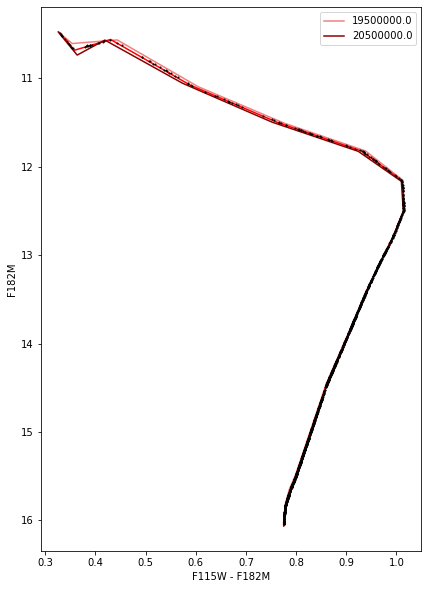

In [10]:
fig, axes = py.subplots(figsize=(15, 10))

# plot CMD
py.subplot(1, 2, 1)
for i in range(len(idx_arr)):
    idx = idx_arr[i]
    if i == 0:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'lightcoral', label=level_age_arr[i])
    elif i == len(idx_arr) - 1:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'darkred', label=level_age_arr[i])
    else:
        py.plot(instances[idx].points[filters[0]] - instances[idx].points[filters[1]], 
           instances[idx].points[filters[1]], 'red', label='')
    
py.xlabel('F115W - F182M')
py.ylabel('F182M')
py.gca().invert_yaxis()
py.legend()

for i in range(len(stars)):
    if stars[i] is None:
        continue
    py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')
    